[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/emilianodesu/RLA2/blob/main/cliff-walking.ipynb)

# Q-Learning

This notebook will explore the implementation of a Temporal-Difference (TD) method, Q-Learning, on the CliffWalking environment.

* Q-Learning Algorithm for Gym based environments

### What you will learn?
* Implement Q-Learning Algorithm
* Use Q-Learning on Cliffwalking and Environments

## 1. Imports and Utilities

In [18]:
!pip install gymnasium pyvirtualdisplay
!apt-get install -y xvfb ffmpeg
!pip install moviepy

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.15).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


In [19]:
import sys
import os
import gymnasium as gym
import numpy as np
import random
import glob
import io
import base64
from collections import namedtuple
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import HTML, display
from gymnasium.wrappers import RecordVideo
from pyvirtualdisplay import Display

display = Display(visible=0, size=(1400, 900))
display.start()

EpisodeStats = namedtuple("Stats",["episode_lengths", "episode_rewards"])

### Utility functions

#### Plot Values

In [20]:
def plot_episode_stats(stats, smoothing_window=10, no_show=False):
    """Function to plot the Episode statistics
    Adapted from: https://github.com/dennybritz/reinforcement-learning/blob/master/lib/plotting.py"""
    # Plot the episode length over time
    fig1 = plt.figure(figsize=(10, 5))
    plt.plot(stats.episode_lengths)
    plt.xlabel("Episode")
    plt.ylabel("Episode Length")
    plt.title("Episode Length over Time")
    if no_show:
        plt.close(fig1)
    else:
        plt.show(fig1)

    # Plot the episode reward over time
    fig2 = plt.figure(figsize=(10, 5))
    rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    if no_show:
        plt.close(fig2)
    else:
        plt.show(fig2)

    # Plot time steps and episode number
    fig3 = plt.figure(figsize=(10, 5))
    plt.plot(np.cumsum(stats.episode_lengths), np.arange(len(stats.episode_lengths)))
    plt.xlabel("Time Steps")
    plt.ylabel("Episode")
    plt.title("Episode per time step")
    if no_show:
        plt.close(fig3)
    else:
        plt.show(fig3)

    return fig1, fig2, fig3

In [21]:
def plot_values(V, shape):
    """Plot State Values"""
    # Reshape the value function V to the given shape
    V = np.reshape(V, shape)

    # Create a new figure with a specific size
    fig = plt.figure(figsize=(15, 5))

    # Add a subplot to the figure. 111 means 1x1 grid, first subplot.
    ax = fig.add_subplot(111)

    # Display the reshaped value function V as an image on the axes
    im = ax.imshow(V, cmap='cool')

    # For each value in V, annotate the plot with the value's rounded label
    for (j, i), label in np.ndenumerate(V):
        ax.text(i, j, np.round(label, 3), ha='center', va='center', fontsize=14)

    # Disable ticks and tick labels for both x and y axes
    plt.tick_params(bottom='off', left='off', labelbottom='off', labelleft='off')

    # Set the title for the plot
    plt.title('State-Value Function')

    # Display the plot
    plt.show()

#### Simulate and show video

In [22]:
def simulate_and_show_video(env_id, Q, epsilon):
    """
    Simulate an environment using a given policy and display the video.

    Parameters:
    - env_id: The string ID of the environment to simulate.
    - Q: The action-value function (Q-table).
    - epsilon: The epsilon value for the epsilon-greedy policy.


    Returns:
    - HTML object if video was captured, or a message indicating no videos were found.
    """
    video_folder = f"./{env_id}_videos"

    # Create the environment with the specified render_mode and wrap it
    # The RecordVideo wrapper handles the video creation.
    env = gym.make(env_id, render_mode='rgb_array')
    env = RecordVideo(env, video_folder=video_folder)

    state, info = env.reset()
    done = False

    while not done:
        action = epsilon_greedy_policy(Q, state, epsilon, env)  # Use epsilon_greedy_policy to select action
        state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

    # Close the environment, which finalizes the video recording.
    env.close()

    # Look for the '.mp4' files in the correct directory
    mp4list = glob.glob(f'{video_folder}/*.mp4')

    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)

        # Clean up the directory after displaying the video
        for file in mp4list:
            os.remove(file)
        os.rmdir(video_folder)

        return HTML(data=f'''<video alt="test" autoplay loop controls style="height: 400px;">
                        <source src="data:video/mp4;base64,{encoded.decode('ascii')}" type="video/mp4" />
                      </video>''')
    else:
        return "No videos found or error during video creation."

In [23]:
def simulate_and_show_video_with_policy(env_id, policy):
    """
    Simulate an environment using a given policy and display the video.

    Parameters:
    - env_id: The string ID of the environment to simulate.
    - policy: The policy to use for action selection.

    Returns:
    - HTML object if video was captured, or a message indicating no videos were found.
    """
    video_folder = f"./{env_id}_videos_policy" # Use a different folder name to avoid conflicts

    # Create the environment with the specified render_mode and wrap it
    # The RecordVideo wrapper handles the video creation.
    env = gym.make(env_id, render_mode='rgb_array')
    env = RecordVideo(env, video_folder=video_folder)

    state, info = env.reset()
    done = False

    while not done:
        action = policy[state] # Use the policy to select action
        state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

    # Close the environment, which finalizes the video recording.
    env.close()

    # Look for the '.mp4' files in the correct directory
    mp4list = glob.glob(f'{video_folder}/*.mp4')

    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)

        # Clean up the directory after displaying the video
        for file in mp4list:
            os.remove(file)
        os.rmdir(video_folder)


        return HTML(data=f'''<video alt="test" autoplay loop controls style="height: 400px;">
                        <source src="data:video/mp4;base64,{encoded.decode('ascii')}" type="video/mp4" />
                      </video>''')
    else:
        return "No videos found or error during video creation."

## 2. Q-Learning

### Helper Functions

#### Epsilon Greedy Action Selection

In [24]:
def epsilon_greedy_policy(Q, state, epsilon, env):
    """
    Select an action using epsilon-greedy policy.

    Parameters:
    - Q 2D np array: A 2S array that maps state to action values.
                For example, Q[state] = [0.1, 0.2, 0.4] for a 3-action environment.
    - state (int): Current state of the agent in the environment.

    - epsilon (float): The probability of choosing a random action (exploration factor).
                   It should be between 0 (no exploration) and 1 (only exploration).

    - env: The environment to sample random actions from.

    Returns:
    - action (int): The chosen action based on the epsilon-greedy policy.
    """
    # Generate a random number between 0 and 1. If it's less than epsilon,
    # then choose a random action, else the greedy action (the action with the maximum Q-value for the current state)
    if random.uniform(0, 1) < epsilon:
        return env.action_space.sample()
    else:
        return max(list(range(env.action_space.n)), key=lambda x: Q[state, x])

#### Policy Extraction from Optimal Q-Values

In [25]:
def extract_policy_V_from_Q_flat(Q, env):
    """
    Extract flat policy and state-value function V from Q.

    Params:
    - Q: Action-value function.
    - env: The environment to extract policy and V for.

    Returns:
    - policy: Derived flat policy from Q.
    - V: Derived flat state-value function from Q.
    """

    n_states = env.observation_space.n
    policy = np.empty(n_states, dtype=np.int64)
    V = np.empty(n_states, dtype=np.float64)

    for state in range(n_states):
            policy[state] = np.argmax(Q[state, :])
            V[state] = np.max(Q[state, :])

    return policy, V

#### Q-Learning Algorithm

In [26]:
def q_learning(env, num_episodes, gamma=1.0, alpha=0.85, epsilon=0.1):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal epsilon-greedy policy.

    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        gamma: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.

    Returns:
        Q is the optimal action-value function,
        stats is a named tuple, which returns the episode statistics for plotting
    """

    # Initialize Q values/Table to Zero
    Q = np.zeros((env.observation_space.n, env.action_space.n), dtype=float)

    # Keeps track of useful statistics
    stats = EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))

    # Run through several episodes
    for episode in range(num_episodes):
        # Store cumulative reward of each episodes in r
        r = 0

        # initialize the state,
        state, _ = env.reset()

        # Reset the Episodes time step, will be used for stats
        timeStep = 0

        while True:

            # select the action using epsilon-greedy policy
            action = epsilon_greedy_policy(Q, state, epsilon, env)

            # then perform the action and move to the next state, and receive the reward
            nextstate, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            # Update statistics
            stats.episode_rewards[episode] += reward
            timeStep += 1
            stats.episode_lengths[episode] = timeStep

            # Calculate the Q-value of previous state using our update rule
            # Q[(state,action)] += alpha * (reward + gamma * Q[(nextstate,nextBestaction)]-Q[(state,action)])
            # Now, select the next BEST ACTION using epsilon greedy policy
            best_next_action = np.argmax(Q[nextstate, :])
            TD_target = reward + gamma * Q[nextstate, best_next_action]
            TD_error = TD_target - Q[state, action]

            Q[state, action] += alpha * TD_error

            # Update the state and BUT NOT action with next action and next state
            state = nextstate

            # store the rewards
            r += reward

            # Break the loop, if it is the terminal state of the episode
            if done:
                break
        # print("Total Reward : ", r)
    return Q, stats

## 3. Running Q-Learning on CliffWalking Environment

### CliffWalking Environment Exploration

The CliffWalking environment is a standard undiscounted, episodic task, with start and goal states, and the usual actions causing movement up, down, right, and left. The reward is -1 on all transitions except those into the region marked "The Cliff". Stepping into this region incurs a reward of -100 and sends the agent instantly back to the start.

In [27]:
# Create an instance of the 'CliffWalking-v1' environment.
# 'CliffWalking' is a standard gridworld environment where the agent has to navigate from a start state to a goal state,
# avoiding falling off a cliff.
env = gym.make('CliffWalking-v1')

# Print the action space of the environment.
# This will show the number of possible actions an agent can take in the environment.
print(env.action_space)

# Print the observation space of the environment.
# This will show the number of possible states (or observations) an agent can encounter in the environment.
print(env.observation_space)

Discrete(4)
Discrete(48)


#### Training the Agent using Q-Learning

In [28]:
# Train agent using the Q-Learning algorithm
Q_table, stats = q_learning(env, 5000, gamma=1.0, alpha=0.5, epsilon=0.1)

#### Extract the Optimal Policy and Visualize the Results

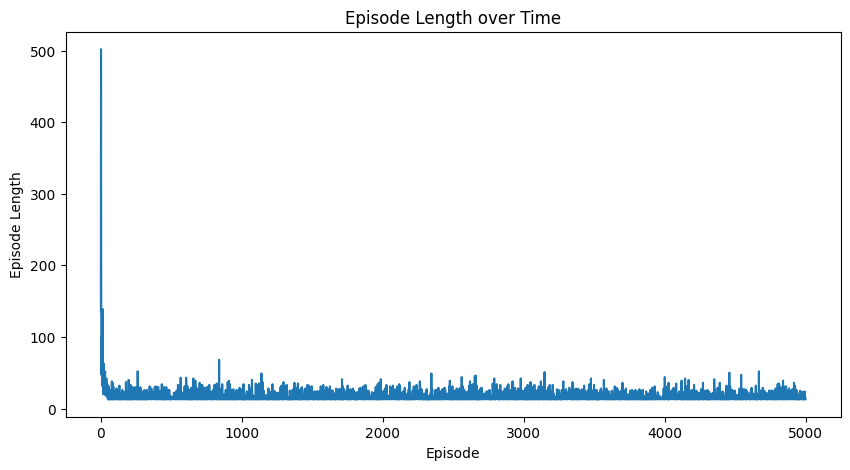

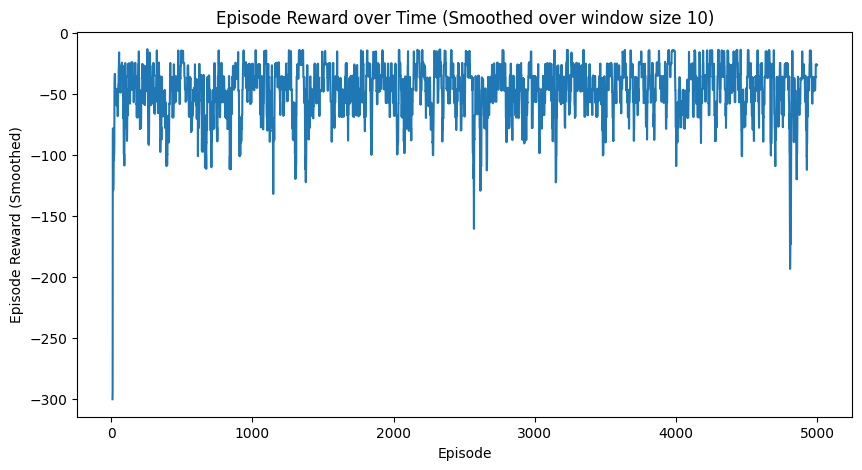

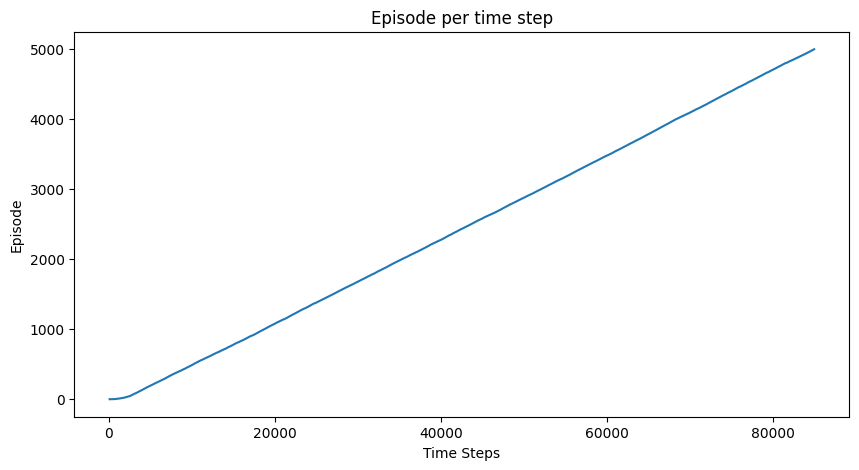

(<Figure size 1000x500 with 1 Axes>,
 <Figure size 1000x500 with 1 Axes>,
 <Figure size 1000x500 with 1 Axes>)

In [29]:
# The Episode Statistics
plot_episode_stats(stats)

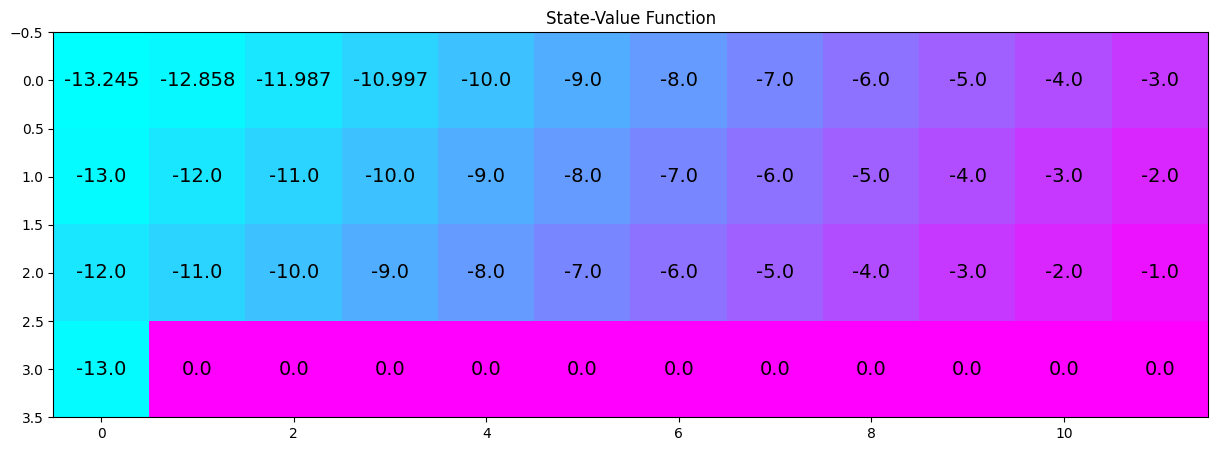

In [30]:
# Extract the optimal policy and corresponding state-value function (V)
# from the action-value function (Q_table) using the 'extract_policy_V_from_Q_flat' function.
# 'Q_table' is the action-value function derived from the Q-Learning algorithm.
policy_QL, V_QL = extract_policy_V_from_Q_flat(Q_table, env)

# Visualize the state-value function (V_table) using the 'plot_values' function.
# The state-value function is reshaped into a grid of size (4, 12) for visualization.
# In the context of the 'CliffWalking-v1' environment, the grid represents the layout of the environment
# with 4 rows and 12 columns.
plot_values(V_QL, (4, 12))

#### Simulate the optimal policy and display the video

In [31]:
# Simulate the environment using the optimal policy suggested by Q-Learning and display the video
simulate_and_show_video('CliffWalking-v1', Q_table, epsilon=0.1)